# Курсовой проект


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender  # нужен для одного трюка
from implicit.nearest_neighbours import bm25_weight, tfidf_weight


import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

# Модель второго уровня
from lightgbm import LGBMClassifier

In [73]:
data = pd.read_csv('data/retail_train.csv')
validation = pd.read_csv('data/retail_test1.csv')

item_features = pd.read_csv('data/product.csv')
user_features = pd.read_csv('data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

### Обучающая и тестовая выборки

In [74]:
data_train = data.copy()
data_val = validation.copy()

result = data_val.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']

In [75]:
data_train

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2396799,1613,41655820646,663,16102849,1,2.00,3262,-1.15,1231,95,0.0,0.0
2396800,1001,41655829421,663,13217063,1,1.69,3131,0.00,2231,95,0.0,0.0
2396801,1001,41655829421,663,13217800,1,1.69,3131,0.00,2231,95,0.0,0.0
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0


### Бейзлайн

In [76]:
top_train = list(data_train['item_id'].value_counts().keys())

In [77]:
result.apply(lambda row: precision_at_k(top_train[:5], row['actual']), axis=1).mean()

0.19363395225463945

Наблюдение: топ 5 наиболее часто покупаемых товаров выглядит очень неплохо. Отфильтруем наиболее покупаемые и т.д.

#### Префильтрация обучающей выборки

* Уберем самые популярные товары (их и так купят)
* Уберем самые НЕ популярные товары (их и так НЕ купят)
* Уберем товары, которые не продавались за последние N недель
* Возьмем топ по популярности

In [78]:
data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=5000)

In [79]:
top_train = list(data_train['item_id'].value_counts().keys())
result.apply(lambda row: precision_at_k(top_train, row['actual']), axis=1).mean()

0.17549071618036888

## ML-модель

In [80]:
# Функции обработки пользователей, отсутствующих в трейне (рекомендует для них топ по по полярности)
def rec_als(recommender, x, N=500):
    try:
        return recommender.get_als_recommendations(x, N=N)
    except:
        return top_train

def rec_own(recommender, x, N=500):
    try:
        return recommender.get_own_recommendations(x, N=N)
    except:
        return top_train
    
def rec_similar(recommender, x, N=500):
    try:
        return recommender.get_similar_items_recommendation(x, N=N)
    except:
        return top_train

In [81]:
recommender = MainRecommender(data_train)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [82]:
%%time
result[f'get_als_recommendations'] = result['user_id'].apply(lambda x: rec_als(recommender, x))
result[f'get_own_recommendations'] = result['user_id'].apply(lambda x: rec_own(recommender, x))
result[f'get_similar_items_recommendation'] = result['user_id'].apply(lambda x: rec_similar(recommender, x))

Wall time: 51.1 s


In [83]:
for i in ['get_als_recommendations', 'get_own_recommendations', 'get_similar_items_recommendation']:
    print(i,':', result.apply(lambda row: precision_at_k(row[i], row['actual']), axis=1).mean())

get_als_recommendations : 0.1553315649867361
get_own_recommendations : 0.1855702917771865
get_similar_items_recommendation : 0.07140583554376696


#### Поэкспериментируем с меньшими значениями take_n_popular

In [84]:
take_n_popular = [10, 50, 100, 1000, 2000]
n_get_als_recommendations, n_get_own_recommendations, n_get_similar_items_recommendation = {}, {}, {}
val_1 = data_val.copy()

for n in take_n_popular:
    
    train_1 = data.copy()
    train_1 = prefilter_items(train_1, item_features=item_features, take_n_popular=n)
    val_1 = val_1.loc[val_1['user_id'].isin(list(train_1['user_id'].unique()))]
    
    recommender_1 = MainRecommender(train_1)
    
    result_1 = val_1.groupby('user_id')['item_id'].unique().reset_index()
    result_1.columns=['user_id', 'actual']
    
    result_1[f'get_als_recommendations'] = result_1['user_id'].apply(lambda x: recommender_1.get_als_recommendations(x))
    result_1[f'get_own_recommendations'] = result_1['user_id'].apply(lambda x: recommender_1.get_own_recommendations(x))
    result_1[f'get_similar_items_recommendation'] = result_1['user_id'].apply(lambda x: recommender_1.get_similar_items_recommendation(x))

    n_get_als_recommendations[n] = result_1.apply(lambda row: precision_at_k(row['get_als_recommendations'], row['actual']), axis=1).mean()
    n_get_own_recommendations[n] = result_1.apply(lambda row: precision_at_k(row['get_own_recommendations'], row['actual']), axis=1).mean()
    n_get_similar_items_recommendation[n] = result_1.apply(lambda row: precision_at_k(row['get_similar_items_recommendation'], row['actual']), axis=1).mean()

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

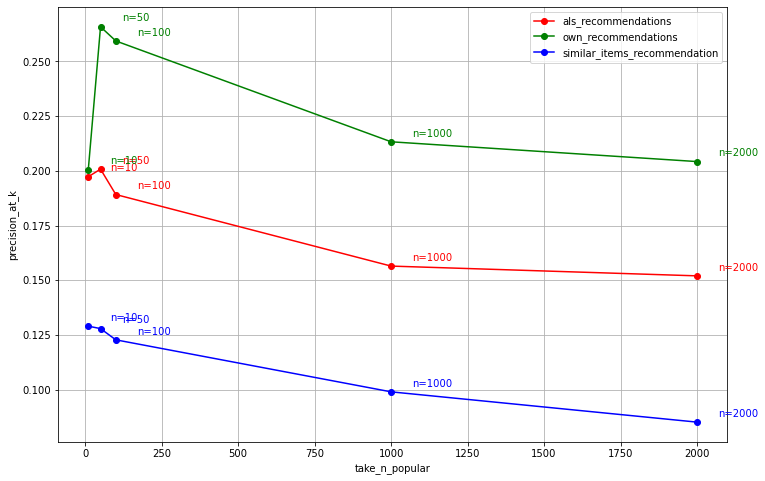

In [85]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(n_get_als_recommendations.keys(), n_get_als_recommendations.values(), 'ro-', label = 'als_recommendations')
ax.plot(n_get_own_recommendations.keys(), n_get_own_recommendations.values(), 'go-', label = 'own_recommendations')
ax.plot(n_get_similar_items_recommendation.keys(), n_get_similar_items_recommendation.values(), 'bo-', label = 'similar_items_recommendation')
ax.grid()

ax.set_xlabel('take_n_popular')
ax.set_ylabel('precision_at_k')

for key in n_get_als_recommendations.keys():
    plt.text(key+70, n_get_als_recommendations[key]+0.0025, f'n={key}', color='r')
for key in n_get_own_recommendations.keys():
    plt.text(key+70, n_get_own_recommendations[key]+0.0025, f'n={key}', color='g')
for key in n_get_similar_items_recommendation.keys():
    plt.text(key+70, n_get_similar_items_recommendation[key]+0.0025, f'n={key}', color='b')
    
    
plt.legend()

plt.show()

Наблюдение: лучшие результаты на get_own_recommendations при take_n_popular = 50

### Модель lvl 1

In [86]:
data_train = data.copy()
data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=50)
recommender = MainRecommender(data_train)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [87]:
data_val = validation.copy()
result = data_val.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result[f'get_own_recommendations'] = result['user_id'].apply(lambda x: rec_own(recommender, x, N=50))

In [88]:
result.apply(lambda row: precision_at_k(row['get_own_recommendations'], row['actual']), axis=1).mean()

0.2566578249336848

Наблюдение: похоже, целевое значение метрики уже достигнуто

### Модель lvl 2

In [89]:
data_train.shape

(139082, 12)

In [90]:
train_lvl_2 = data_train.copy()
train_lvl_2

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
949830,1770,31527813342,307,904360,1,0.99,432,0.00,102,45,0.0,0.0
952351,2472,31528114102,307,981760,1,1.19,391,0.00,34,45,0.0,0.0
952901,816,31528169353,307,862349,1,1.00,380,-0.99,28,45,0.0,0.0
952902,816,31528169353,307,883404,1,1.00,380,-0.29,28,45,0.0,0.0
952906,816,31528169353,307,1082185,1,1.10,380,0.00,28,45,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2396657,1776,41653231994,663,1082185,1,0.56,324,-0.38,1657,95,0.0,0.0
2396663,1989,41653235833,663,866227,2,1.00,343,0.00,1025,95,0.0,0.0
2396725,1754,41653239425,663,1098066,1,0.88,343,-0.41,1609,95,0.0,0.0
2396728,1754,41653239425,663,5569230,4,10.00,343,-8.76,1609,95,0.0,0.0


In [91]:
train_users = pd.DataFrame(train_lvl_2['user_id'].unique())
train_users.columns = ['user_id']

In [92]:
train_users['candidates'] = train_users['user_id'].apply(lambda x: rec_own(recommender, x, N=50))

In [93]:
s = train_users.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'
s = s.astype(int)

train_users = train_users.drop('candidates', axis=1).join(s)
train_users['flag'] = 1

train_users.head(4)

,user_id,item_id,flag
0,1770,995242,1
0,1770,961554,1
0,1770,834484,1
0,1770,994928,1


In [94]:
targets_lvl_2 = train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1 

targets_lvl_2 = train_users.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

In [95]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,1770,995242,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1770,995242,1.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
targets_lvl_2['target'].value_counts()

1.0    243101
0.0     58556
Name: target, dtype: int64

In [97]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

cat_feats = X_train.columns[2:].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [98]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\User\anaconda3\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


LGBMClassifier(categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product', 'age_desc',
                                   'marital_status_code', 'income_desc',
                                   'homeowner_desc', 'hh_comp_desc',
                                   'household_size_desc', 'kid_category_desc'],
               max_depth=7, objective='binary')

In [99]:
train_preds = lgb.predict_proba(X_train)

In [100]:
pd.DataFrame(train_preds).describe()

,0,1
count,301657.000000,301657.000000
mean,0.194174,0.805826
std,0.154364,0.154364
min,0.002044,0.043328
25%,0.060943,0.679121
50%,0.142559,0.857441
75%,0.320879,0.939057
max,0.956672,0.997956


In [101]:
result_train = pd.concat([X_train, pd.DataFrame(train_preds)[0]], axis=1)
result_train = result_train.drop_duplicates()
result_train = result_train[result_train.groupby('user_id')[0].rank(ascending=False) <= 5]
result_train

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,0
22,1770,834484,2,PRODUCE,National,ONIONS,ONIONS OTHER,48 CT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.387656
53,1770,862349,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.413161
63,1770,903325,2,PRODUCE,National,BROCCOLI/CAULIFLOWER,BROCCOLI WHOLE&CROWNS,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.447961
135,1770,1070820,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.373569
137,1770,1058997,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.367481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301640,1386,903325,2,PRODUCE,National,BROCCOLI/CAULIFLOWER,BROCCOLI WHOLE&CROWNS,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.517970
301642,1386,834484,2,PRODUCE,National,ONIONS,ONIONS OTHER,48 CT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.486700
301646,1386,866227,2,PASTRY,National,BREAKFAST SWEETS,SW GDS:DONUTS,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465921
301649,1386,914190,317,GROCERY,National,CHEESE,CREAM CHEESE,L 8OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.485853


In [102]:
result_train = result_train.groupby('user_id')['item_id'].unique().reset_index()
result_train = result_train.rename(columns={'item_id': 'recs'})

In [103]:
result_train

,user_id,recs
0,1,"[908531, 1098066, 844179, 859075, 1065593]"
1,2,"[1007195, 914190, 859075, 834484, 1065593]"
2,3,"[844179, 859075, 903325, 834484, 1065593]"
3,4,"[859075, 834484, 1065593, 866227, 914190]"
4,6,"[834484, 903325, 866227, 1007195, 844179]"
...,...,...
2390,2496,"[1044078, 1126899, 1070820, 1058997, 862349]"
2391,2497,"[1070820, 1126899, 1044078, 1098066, 908531]"
2392,2498,"[1133018, 908531, 916122, 1058997, 1044078]"
2393,2499,"[1044078, 1133018, 995785, 916122, 1058997]"


### Предсказания для теста

#### На обученном трейне по id

In [104]:
result_test = result.merge(result_train, on='user_id')

In [105]:
result_test.apply(lambda row: precision_at_k(row['recs'], row['actual']), axis=1).mean()

0.0527282549972991

#### Через predict_proba для данных test на моделе lgb, обученно на train

In [109]:
test_users = pd.DataFrame(data_val['user_id'].unique())
test_users.columns = ['user_id']
test_users['candidates'] = test_users['user_id'].apply(lambda x: rec_own(recommender, x, N=50))

In [110]:
s = test_users.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'
s = s.astype(int)

In [111]:
test_users = test_users.drop('candidates', axis=1).join(s)
test_users['flag'] = 1

In [112]:
targets_test = data_val[['user_id', 'item_id']].copy()
targets_test['target'] = 1 

targets_test = test_users.merge(targets_test, on=['user_id', 'item_id'], how='left')

targets_test['target'].fillna(0, inplace= True)
targets_test.drop('flag', axis=1, inplace=True)

In [113]:
targets_test = targets_test.merge(item_features, on='item_id', how='left')
targets_test = targets_test.merge(user_features, on='user_id', how='left')

In [114]:
X_test = targets_test.drop('target', axis=1)
cat_feats = X_test.columns[2:].tolist()
X_test[cat_feats] = X_test[cat_feats].astype('category')

In [115]:
test_preds = lgb.predict_proba(X_test)

In [116]:
result_test = pd.concat([X_test, pd.DataFrame(test_preds)[0]], axis=1)
result_test = result_test.drop_duplicates()
result_test = result_test[result_test.groupby('user_id')[0].rank(ascending=False) <= 5]
result_test

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,0
40,1340,859075,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.450898
41,1340,903325,2,PRODUCE,National,BROCCOLI/CAULIFLOWER,BROCCOLI WHOLE&CROWNS,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.509341
43,1340,834484,2,PRODUCE,National,ONIONS,ONIONS OTHER,48 CT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.478076
44,1340,1065593,595,GROCERY,National,BATH TISSUES,TOILET TISSUE,83.5 SQ FT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.456410
47,1340,866227,2,PASTRY,National,BREAKFAST SWEETS,SW GDS:DONUTS,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.457337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266221,247,878996,2,PRODUCE,National,GRAPES,GRAPES RED,18 LB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.561688
266224,247,859075,69,GROCERY,Private,CHEESE,SHREDDED CHEESE,8 OZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.552926
266225,247,903325,2,PRODUCE,National,BROCCOLI/CAULIFLOWER,BROCCOLI WHOLE&CROWNS,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633371
266227,247,834484,2,PRODUCE,National,ONIONS,ONIONS OTHER,48 CT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.560597


In [117]:
result_test = result_test.groupby('user_id')['item_id'].unique().reset_index()
result_test = result_test.rename(columns={'item_id': 'recs'})

In [118]:
result_test = pd.concat([result, result_test['recs']], axis=1)

In [119]:
result_test.apply(lambda row: precision_at_k(row['recs'], row['actual']), axis=1).mean()

0.0517771883289128

##### В общем ничего путного не получилось со второй моделью. Так что оставляем первый вариант...

In [120]:
result.apply(lambda row: precision_at_k(row['get_own_recommendations'], row['actual']), axis=1).mean()

0.2566578249336848

In [136]:
csv_res = result[['user_id', 'get_own_recommendations']].copy().set_index('user_id').rename(columns={'get_own_recommendations': 'recommendations'})

In [137]:
csv_res.to_csv('recommendations.csv')